# Homework 1- Coding Part 2
<font color="red"> due on Mar 21 11:59 PM </font><br>
name the notebook as ``<your unique name>_hw1.ipynb``<br>
total points: 30

# How to use decision trees in practice

In this notebook, we illustrate how to use tree-based models to gain insight and make predictions. 

To demonstrate regression trees we predict returns, and for the classification case, we return to the example of positive and negative asset price moves.

In [1]:
%matplotlib inline

# make sure you have installed all required packages
# note: conda install python-graphviz instead of pip install graphviz to avoid unexpected error

import warnings
import os
from pathlib import Path
#import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve,  accuracy_score

# I made a change here because our sklear has different version

from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy.interpolate import interp1d, interp2d

In [2]:
# ignore warning messages and set plot style
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Get Data

Here, we read the data needed for this project

A brief summary of the data: the returns column is the target and the rest of columns are the features. The features are:
- the monthly returns for previous months
- the year and month of the date, 
- the size of the compmay ( the size is basically the size at the end of the interval but it is a good proxy),
- the age of the company, 
- sector

In [3]:
with pd.HDFStore('data.h5') as store:
    data = store['data']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 154290 entries, ('A', Timestamp('2011-04-30 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 61 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   returns                154290 non-null  float64
 1   t-1                    154290 non-null  float64
 2   t-2                    154290 non-null  float64
 3   t-3                    154290 non-null  float64
 4   t-4                    154290 non-null  float64
 5   t-5                    154290 non-null  float64
 6   t-6                    154290 non-null  float64
 7   t-7                    154290 non-null  float64
 8   t-8                    154290 non-null  float64
 9   t-9                    154290 non-null  float64
 10  t-10                   154290 non-null  float64
 11  t-11                   154290 non-null  float64
 12  t-12                   154290 non-null  float64
 13  year_2011      

### Market Returns

#### <font color="red"> =================================== Todo 1 =================================== </font>

<font color="blue">In the following cell, put the features data in ``X``, the target column (``returns``) in variable ``y``</font>

In [4]:
# Please uncomment the following code and implement your code here
data = data.fillna(0)
y = data["returns"]
X = data.drop(["returns"], axis=1)

<font color="blue">Plot the daily cumulative returns of the market (average return of stocks in the market)
- <font color="blue"> Hint: ``numpy.cumprod()`` method will be useful

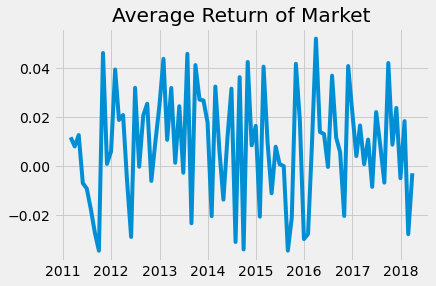

In [5]:
# Please uncomment the following code and implement your code here
# get all the stock codes and store them in list
stock_codes = list(set(data.index.get_level_values(0)))
# number of stocks
num = len(stock_codes)
return_data = pd.DataFrame()
for i in stock_codes:
    data_stock = y.loc[i]
    return_data = pd.concat([return_data, data_stock], axis = 1)
# fill up all the NaN value with 0 and calculate the total returns for each stock
return_data["average return"] = return_data.apply(lambda x:x.sum(),axis =1)/num
plt.plot(return_data["average return"])
plt.title("Average Return of Market")
plt.show()

### Explore Data

<font color="blue">print the min, 10%, 20%, ..., 90% max percentiles of returns (``y``) </font>

In [6]:
# Please uncomment the following code and implement your code here
print(f"The minimum value of returns is {y.min()}")
for i in list(np.linspace(0.1, 0.9, num=9)):
    print(f"The {round(i*100, 2)}% max percentiles of returns is {y.quantile(i)}")
print(f"The maximum value of returns is {y.max()}")

The minimum value of returns is -0.14772727272727282
The 10.0% max percentiles of returns is -0.07818930462647782
The 20.0% max percentiles of returns is -0.04656514565317702
The 30.0% max percentiles of returns is -0.024020529564095623
The 40.0% max percentiles of returns is -0.005719265780669565
The 50.0% max percentiles of returns is 0.00947867298577909
The 60.0% max percentiles of returns is 0.025698611146095413
The 70.0% max percentiles of returns is 0.043590075584033036
The 80.0% max percentiles of returns is 0.06557377049180335
The 90.0% max percentiles of returns is 0.09868448917719709
The maximum value of returns is 0.18153364632240643


### Binary Outcome

<font color="blue">define y_binary to be 1 if y>0 and 0 if y<=0 </font>

In [7]:
# Please uncomment the following code and implement your code here  
data["binary"] = data["returns"]
data["binary"][data.binary > 0] = 1
data["binary"][data.binary <= 0] = 0
y_binary = data["binary"]

#### <font color="orange"> For the following parts, we will use ``y`` as our label for regression problems, and use ``y_binary`` as label for classification problems </font>

### Two Months Lags Only

<font color="blue">define a new DataFrame ``X2`` which only contains lag 1 and lag 2 (``t-1``, `t-2`) </font>

In [8]:
# Please uncomment the following code and implement your code here
X2 = data[["t-1","t-2"]]

#### <font color="red"> =================================== Todo 1 End =================================== </font>

<a id="custom_kfold"></a>
## Custom KFold

We also construct a custom cross-validation class tailored to the format of the data just created, which has pandas MultiIndex with two levels, one for the ticker and one for the data.

`OneStepTimeSeriesSplit` ensures a split of training and validation sets that avoids a lookahead bias by training models using only data up to period T-1 for each stock when validating using data for month T. We will only use one-step-ahead forecasts.

In [9]:
class OneStepTimeSeriesSplit:
    """
    Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'
    """

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, chunk_size):
        for i in range(0, len(l), chunk_size):
            yield l[i:i + chunk_size]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)[:self.test_end])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [10]:
cstss = OneStepTimeSeriesSplit()
res = cstss.split(X)

In [11]:
unique_dates = (X.index
                .get_level_values('date')
                .unique()
                .sort_values(ascending=False)[:cstss.test_end])

dates = X.reset_index()[['date']]
all_res =[]
for test_date in cstss.chunks(unique_dates, 1):
    train_idx = dates[dates.date < min(test_date)].index
    test_idx = dates[dates.date.isin(test_date)].index

In [12]:
def regression_benchmark():
    '''
    '''
    rmse = []
    for train_idx, test_idx in cv.split(X):
        mean = y.iloc[train_idx].mean()
        data = y.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        rmse.append(np.sqrt(mean_squared_error(data.y_test, data.y_pred))) 
    return np.mean(rmse)

In [13]:
def classification_benchmark():
    auc = []
    for train_idx, test_idx in cv.split(X):
        mean = y_binary.iloc[train_idx].mean()
        data = y_binary.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        auc.append(roc_auc_score(data.y_test, data.y_pred))
    return np.mean(auc)

## Simple Regression Tree



Recall that, given a training set, the algorithm iterates over the predictors, $X_1, X_2, ..., X_p$, and possible cutpoints, $s_1, s_2, ..., s_N$, to find an optimal combination. The optimal rule splits the feature space into two regions, $\{X\mid X_i < s_j\}$ and $\{X\mid X_i > s_j\}$, with values for the $X_i$ feature either below or above the $s_j$ threshold so that predictions based on the training subsets maximize the reduction of the squared residuals relative to the current node.

### Configure Tree

Let's start with a simplified example to facilitate visualization and only use two months of lagged returns to predict the following month

#### <font color="red"> =================================== Todo 2 =================================== </font>

<font color="blue">Build a regression decision tree on (X2, y), with following parameters</font>
- criterion='mse'
- splitter='best'
- max_depth=4
- min_samples_split=2
- min_samples_leaf=1
- min_weight_fraction_leaf=0.0
- max_features=None
- random_state=42
- max_leaf_nodes=None
- min_impurity_decrease=0.0
- min_impurity_split=None
- presort=False

And train the tree model

In [14]:
# Please uncomment the following code and implement your code here
# First we split the train data set and the test data set
train_X2,test_X2,train_y,test_y, train_y_label, test_y_label = train_test_split(X2,
                                                 y,
                                                 y_binary,
                                                 test_size=0.1,
                                                 random_state=2021)

regressor = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 max_depth=4,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)
reg_tree = regressor.fit(train_X2,train_y)

### Visualize Tree

You can visualize the tree using the ``graphviz`` library (see GitHub for installation instructions) because sklearn can output a description of the tree using the .dot language used by that library. 

You can configure the output to include feature and class labels and limit the number of levels to keep the chart readable, as follows:

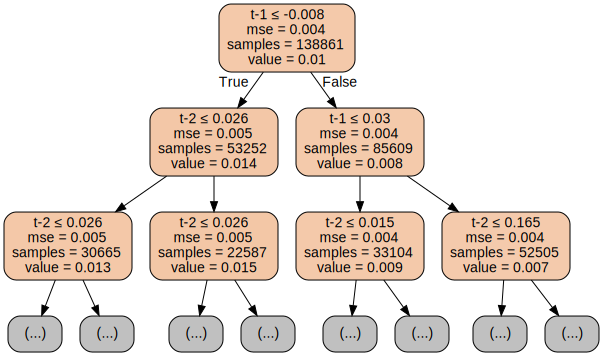

In [15]:
# Please uncomment the following code

out_file = 'reg_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

#### <font color="red"> =================================== Todo 2 End =================================== </font>

### Compare with Linear Regression

#### <font color="red"> =================================== Todo 3 =================================== </font>

fit a linear regression (default parameters) on ``X2`` and ``y``, print the ``coefficients`` and ``intercept``
- name your linear model as ``lin_reg``

In [16]:
# Please uncomment the following code and implement your code here
lin_reg = LinearRegression().fit(train_X2,train_y)
print(f"The coefficients of the linear regression are {lin_reg.coef_}")
print(f"The intercept of the linear regression is {lin_reg.intercept_}")

The coefficients of the linear regression are [-0.0388674   0.00807097]
The intercept of the linear regression is 0.010581898276350348


### Linear Regression vs Regressin Tree Decision Surfaces

To further illustrate the different assumptions about the functional form of the relationships between the input variables and the output, we can visualize current return predictions as a function of the feature space, that is, as a function of the range of values for the lagged returns. The following figure shows the current period return as a function of returns one and two periods ago for linear regression and the regression tree:

The linear-regression model result on the right side underlines the linearity of the relationship between lagged and current returns, whereas the regression tree chart on the left illustrates the non-linear relationship encoded in the recursive partitioning of the feature space.

<font color="blue">Plot the decision surface of linear regression and regression decision tree </font>
- <font color="blue">hint: ``meshgrid`` method in numpy and ``contourf`` in matplotlib is useful for doing this</font>

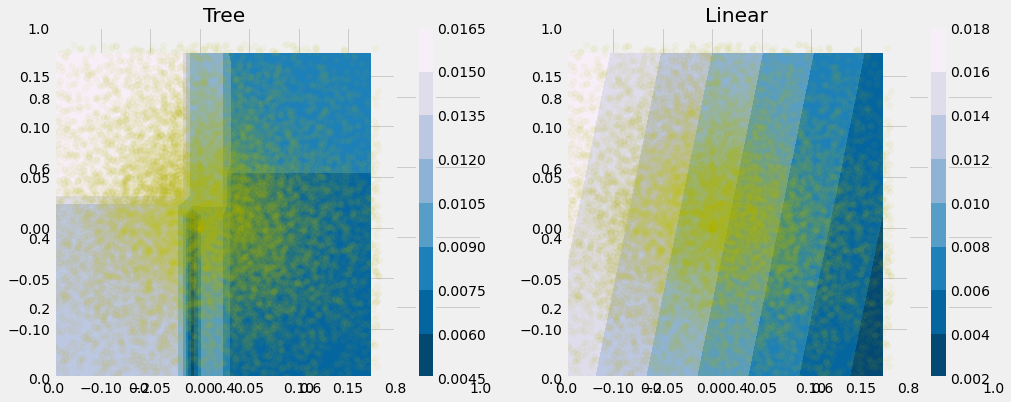

In [17]:
# Please uncomment the following code and implement your code here
min1, max1 = test_X2["t-1"].min(), test_X2["t-1"].max()
min2, max2 = test_X2["t-2"].min(), test_X2["t-2"].max()
x1_scale = np.arange(min1, max1, 0.01)
x2_scale = np.arange(min2, max2, 0.01)
x_grid, y_grid = np.meshgrid(x1_scale, x2_scale)
# flatten each grid to a vector
x_g, y_g = x_grid.flatten(), y_grid.flatten()
x_g, y_g = x_g.reshape((len(x_g), 1)), y_g.reshape((len(y_g), 1))
grid = np.hstack((x_g, y_g))

y_pred_l = lin_reg.predict(grid)
y_pred_t = reg_tree.predict(grid)

pp_grid1 = y_pred_t.reshape(x_grid.shape)
pp_grid2 = y_pred_l.reshape(x_grid.shape)
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax1 = fig.add_subplot(121)
surface1 = plt.contourf(x_grid, y_grid, pp_grid1, cmap=cm.PuBu_r)
plt.scatter(test_X2["t-1"], test_X2["t-2"], c="y", alpha= 0.05)# show the plot
plt.title("Tree")
plt.colorbar(surface1)
ax2 = fig.add_subplot(122)
surface2 = plt.contourf(x_grid, y_grid, pp_grid2, cmap=cm.PuBu_r)
plt.scatter(test_X2["t-1"], test_X2["t-2"], c="y", alpha= 0.05)# show the plot
plt.title("Linear")
plt.colorbar(surface2)

<font color="blue">Whats the difference of the Linear regression surface and the regression tree surface?</font>

Please answer your questions with Notebook Markdown:

The difference between linear regression surface and the regression tree surface is that the linear regression's decision surface shows that there is some linearity of the relationship between lagged("t-1","t-2") and current returns. But the tree regression's decision surface does not show it.


#### <font color="red"> =================================== Todo 3 End =================================== </font>

## Simple Classification Tree

A classification tree works just like the regression version, except that categorical nature of the outcome requires a different approach to making predictions and measuring the loss. While a regression tree predicts the response for an observation assigned to a leaf node using the mean outcome of the associated training samples, a classification tree instead uses the mode, that is, the most common class among the training samples in the relevant region. A classification tree can also generate probabilistic predictions based on relative class frequencies.

### Loss Functions

When growing a classification tree, we also use recursive binary splitting but, instead of evaluating the quality of a decision rule using the reduction of the mean-squared error, we can use the classification error rate, which is simply the fraction of the training samples in a given (leave) node that do not belong to the most common class.

However, the alternative measures, Gini Index or Cross-Entropy, are preferred because they are more sensitive to node purity than the classification error rate. Node purity refers to the extent of the preponderance of a single class in a node. A node that only contains samples with outcomes belonging to a single class is pure and imply successful classification for this particular region of the feature space. 

#### <font color="red"> =================================== Todo 4 =================================== </font>

<font color="blue">Implement ``entropy``, ``gini``, ``misclassification_rate`` functions</font>

In [18]:
from scipy.stats import entropy
#def entropy(f):
#    """
#    f: input distribution array, e.g. np.array([0.1, 0.2, 0.3, 0.4])
#    compute and return the entropy of input distribution
#    """
#    pass

def gini(f):
    """
    f: input distribution array, e.g. np.array([0.1, 0.2, 0.3, 0.4])
    compute and return the gini of input distribution
    """
    mad = np.abs(np.subtract.outer(f, f)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(f)
    # Gini coefficient
    g = 0.5 * rmad
    return g

def misclassification_rate(f):
    """
    f: input distribution array, e.g. np.array([0.1, 0.2, 0.3, 0.4])
    compute and return the misclassification rate of input distribution
    """
    mad = np.abs(np.subtract.outer(f, f))
    s = len(mad)
    return s/len(f)

Both the Gini Impurity and the Cross-Entropy measure take on smaller values when the class proportions approach zero or one, that is, when the child nodes become pure as a result of the split and are highest when the class proportions are even or 0.5 in the binary case. 

<font color="blue">Visualizes the values assumed by these two measures and the misclassification error rates across the [0, 1] interval of proportions. </font>

In [19]:
# Please uncomment the following code and implement your code here
# # the distribution array x is already created for you
from scipy.stats import entropy
x = np.linspace(0, 1, 10000)
print(entropy(x))

9.017143171088716


#### <font color="red"> =================================== Todo 4 End =================================== </font>

#### Compare computation time

Gini is often preferred over entropy because it computes faster:

In [20]:
%%timeit
misclassification_rate(x)

745 ms ± 8.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
gini(x)

880 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
entropy(x)

138 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Configure Tree

#### <font color="red"> =================================== Todo 5 =================================== </font>

<font color="blue">Build a classification decision tree on (X2, y), with following parameters</font>
- criterion='gini'
- splitter='best'
- max_depth=4
- min_samples_split=2
- min_samples_leaf=1
- min_weight_fraction_leaf=0.0
- max_features=None
- random_state=42
- max_leaf_nodes=None
- min_impurity_decrease=0.0
- min_impurity_split=None
- class_weight=None
- presort=False

And train the tree model

In [23]:
# Please uncomment the following code and implement your code here
Classifier = DecisionTreeClassifier(criterion='gini',
                                    splitter='best',
                                    max_depth=4,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    class_weight=None,
                                    presort=False)
clf_tree = Classifier.fit(train_X2,train_y_label)

### Visualize Tree

<font color="blue">Do what we did for regression tree</font>

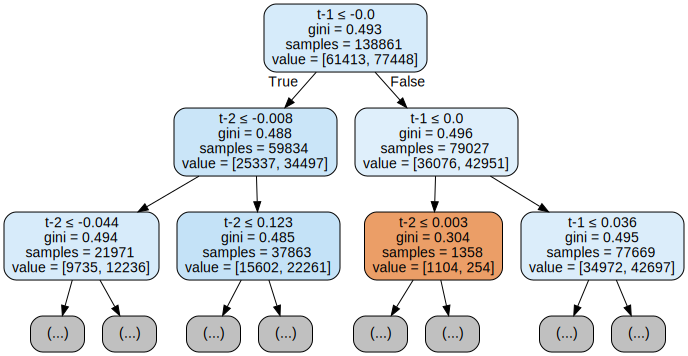

In [24]:
# Please uncomment the following code and implement your code here
out_file = 'clf_tree.dot'
dot_data1 = export_graphviz(clf_tree,
                          out_file=out_file,
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data1 = Path(out_file).read_text()

graphviz.Source(dot_data1)

### Compare with Logistic Regression

<font color="blue">built a Logistic Regression with default paramters, and train the model</font>

In [25]:
# Please uncomment the following code and implement your code here
log_reg = LogisticRegression().fit(train_X2, train_y_label)

<font color="blue"> print the coefficients of logistic regression </font>

In [26]:
# Please uncomment the following code and implement your code here
print(f"The coefficients of the linear regression are {log_reg.coef_}")

The coefficients of the linear regression are [[-0.78905236  0.53187313]]


### Plot Decision Surfaces

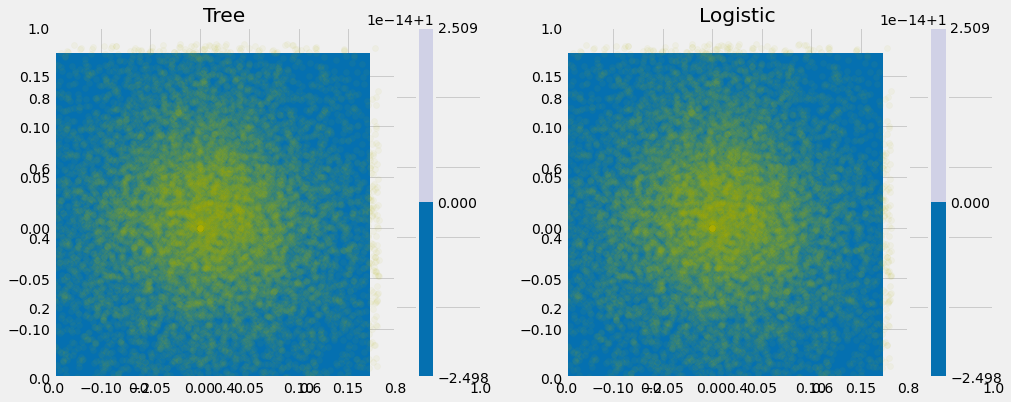

In [27]:
# Please uncomment the following code and implement your code here
min1, max1 = test_X2["t-1"].min(), test_X2["t-1"].max()
min2, max2 = test_X2["t-2"].min(), test_X2["t-2"].max()
x1_scale = np.arange(min1, max1, 0.01)
x2_scale = np.arange(min2, max2, 0.01)
x_grid, y_grid = np.meshgrid(x1_scale, x2_scale)
# flatten each grid to a vector
x_g, y_g = x_grid.flatten(), y_grid.flatten()
x_g, y_g = x_g.reshape((len(x_g), 1)), y_g.reshape((len(y_g), 1))
grid = np.hstack((x_g, y_g))

y_pred_l = log_reg.predict(grid)
y_pred_t = clf_tree.predict(grid)

pp_grid1 = y_pred_t.reshape(x_grid.shape)
pp_grid2 = y_pred_l.reshape(x_grid.shape)
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax1 = fig.add_subplot(121)
surface1 = plt.contourf(x_grid, y_grid, pp_grid1, cmap=cm.PuBu_r)
plt.scatter(test_X2["t-1"], test_X2["t-2"], c="y", alpha= 0.05)# show the plot
plt.title("Tree")
plt.colorbar(surface1)
ax2 = fig.add_subplot(122)
surface2 = plt.contourf(x_grid, y_grid, pp_grid2, cmap=cm.PuBu_r)
plt.scatter(test_X2["t-1"], test_X2["t-2"], c="y", alpha= 0.05)# show the plot
plt.title("Logistic")
plt.colorbar(surface2)


#### <font color="red"> =================================== Todo 5 End =================================== </font>

## Overfitting, Regularization & Parameter Tuning

Decision trees have a strong tendency to overfit, especially when a dataset has a large number of features relative to the number of samples. As discussed in previous chapters, overfitting increases the prediction error because the model does not only learn the signal contained in the training data, but also the noise.
There are several ways to address the risk of overfitting.

Decision trees provide several regularization hyperparameters to limit the growth of a tree and the associated complexity. While every split increases the number of nodes, it also reduces the number of samples available per node to support a prediction. For each additional level, twice the number of samples is needed to populate the new nodes with the same sample density. 

### Decision Tree Parameters

The following table lists key parameters available for this purpose in the sklearn decision tree implementation. After introducing the most important parameters, we will illustrate how to use cross-validation to optimize the hyperparameter settings with respect to the bias-variance tradeoff and lower prediction errors:

| Parameter                | Default | Options                                                                                                                                                               | Description                                                                                                                                                                                                             |
|--------------------------|---------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| criterion                | gini    | Regression: MSE, MAE Classification: Gini impurity, Cross Entropy                                                                                                     | Metric to evaluate split quality.                                                                                                                                                                                       |
| splitter                 | best    | best, random                                                                                                                                                          | How to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.                                                                            |
| max_depth                | None    | int                                                                                                                                                                   | Max # of levels in tree. Split nodes until max_depth is reached or all leaves are pure or all leaves contain less than min_samples_split samples.                                                                       |
| max_features             | None    | None: max_features=n_features; int; float (fraction): int(max_features * n_features)  auto, sqrt: max_features=sqrt(n_features). log2: max_features=log2(n_features). | # of features to consider when evaluating split                                                                                                                                                                         |
| max_leaf_nodes           | None    | None: unlimited # of leaf nodes int                                                                                                                                   | Continue to split nodes that reduce relative impurity the most until reaching max_leaf_nodes.                                                                                                                           |
| min_impurity_decrease    | 0       | float                                                                                                                                                                 | Split node if impurity decreases by at least this value.                                                                                                                                                                |
| min_samples_leaf         | 1       | int; float (as percentage of N)                                                                                                                                       | Minimum # of samples to be at a leaf node. A split will only be considered if there are at least min_samples_leaf training samples in each of the left and right branches. May smoothen the model, esp. for regression. |
| min_samples_split        | 2       | int; float (as percentage of N)                                                                                                                                       | The minimum number of samples required to split an internal node:                                                                                                                                                       |
| min_weight_fraction_leaf | 0       | NA                                                                                                                                                                    | The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided (in fit method).                       |
| presort                  | False   | NA                                                                                                                                                                    | Sort the data to speed up the search for best splits during training. Can slow down training on 'large' datasets but may speed up training on small data or with small max_depth setting.                               |
| class_weight             | None    | balanced: inversely proportional to class frequencies dict: {class_label: weight} list of dicts (for multi-output)                                                    | Weights associated with classes                                                                                                                                                                                         |

The `max_depth` parameter imposes a hard limit on the number of consecutive splits and represents the most straightforward way to cap the growth of a tree.

In [28]:
def plot_cv_results(cv_scores, metric='AUC', parameter='Max. Depth'):
    """
    cv_scores: a dictonary, e.g. {parameter_value: model_score}
    metric: AUC or mse
    """
    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(cv_scores).T
    df = df.rename_axis('tree_depth')
    df = df.rename_axis("node", axis="columns")
    df = df.reset_index()
    df = pd.melt(df, id_vars=['tree_depth'])
    df = df.sort_values( by = ['tree_depth'])
    sns.lineplot(data=df, x="tree_depth", y="value",  ax=ax, lw=2) 
    
    if metric == 'AUC':
        
        ax.axhline(classification_benchmark(), c='red', lw=1, ls='--') 
    else:
        ax.axhline(regression_benchmark(), c='red', lw=1, ls='--')
    
       
    ax.set_title(f'{5}-Fold Cross-Validation Result')
    ax.set_xlabel(parameter)
    ax.set_ylabel(metric)

### Cross-Validation Score

### For Classification Tree

Cross-validation is the most important tool to obtain an unbiased estimate of the generalization error, which in turn permits an informed choice among the various configuration options. sklearn offers several tools to facilitate the process of cross-validating numerous parameter settings, namely the GridSearchCV convenience class that we will illustrate in the next section. 

Use OneStepTimeSeriesSplit for cross validation (set n splits = 10), and then plot the AUC results

In [29]:
cv = OneStepTimeSeriesSplit(n_splits=10)

In [30]:
%%time
clf_results = {}
for max_depth in range(1, 26):
    clf_tree = DecisionTreeClassifier(criterion='gini',
                                      max_depth=max_depth,
                                      min_samples_leaf=5,
                                      random_state=42)
    clf_results[max_depth] = cross_val_score(clf_tree,
                                             X=X,
                                             y=y_binary,
                                             scoring='roc_auc',
                                             n_jobs=-1,
                                             cv=cv)

Wall time: 3min 33s


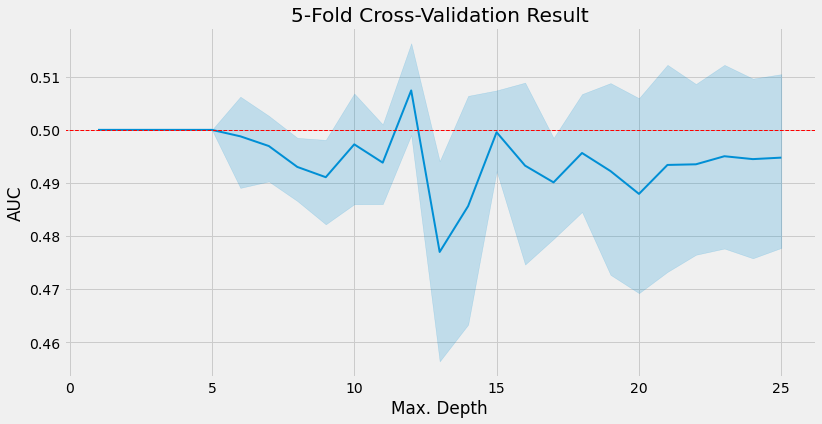

In [31]:
plot_cv_results(clf_results)

### For Regression Tree

#### <font color="red"> =================================== Todo 6 =================================== </font>

<font color="blue">Use OneStepTimeSeriesSplit for cross validation (set n splits = 10) to search the ``best max_depth`` from [1 - 25]

In [32]:
# Please uncomment the following code and implement your code here
reg_results = {}
for max_depth in range(1, 26):
    reg_tree = DecisionTreeRegressor(criterion='gini',
                                      max_depth=max_depth,
                                      min_samples_leaf=5,
                                      random_state=42)
    reg_results[max_depth] = cross_val_score(reg_tree,
                                             X=X,
                                             y=y_binary,
                                             scoring='neg_mean_squared_error',
                                             n_jobs=-1,
                                             cv=cv)

<br>Then plot the ``mse`` results by using plot_cv_results defined above for you </font>

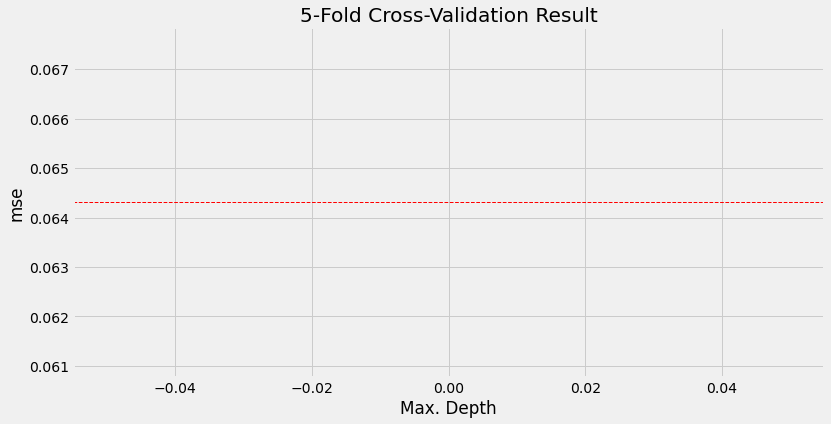

In [33]:
# Please uncomment the following code and implement your code here
plot_cv_results(reg_results,metric='mse')

#### <font color="red"> =================================== Todo 6 End =================================== </font>

### GridSearch

sklearn provides a method to define ranges of values for multiple hyperparameters. It automates the process of cross-validating the various combinations of these parameter values to identify the optimal configuration. Let's walk through the process of automatically tuning your model.

#### Classification Tree

The first step is to instantiate a model object and define a dictionary where the keywords name the hyperparameters, and the values list the parameter settings to be tested:

#### <font color="red"> =================================== Todo 7 =================================== </font>

<font color="blue"> Build a Decision Tree Classifier (set random_state=42), and use grid search to tune the following parameters from given potential values </font>
- <font color="blue">max_depth: 10, 11, ..., 20 </font>
- <font color="blue">min_samples_leaf: 250, 500, 750 </font>
- <font color="blue">max_features: sqrt, auto </font>

<font color="blue">check ``GridSearchCV`` method (set ``refit=True``), name our GridSearchCV model as ``gridsearch_clf`` (make sure you have the same model name)</font>

In [34]:
# Please uncomment the following code and implement your code here
clf_model = DecisionTreeClassifier()
clf_model.fit(train_X2, train_y_label)
parm_grid = {
    "max_depth": [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_samples_leaf": [250, 500, 750],
    "max_features": ["sqrt", "auto"]
}
gridsearch_clf = GridSearchCV(clf_model, parm_grid, cv=5)
gridsearch_clf.fit(train_X2, train_y_label)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                       20],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [250, 500, 750]})

<font color="blue"> Print best values of parameters, and the best score of the tunned model</font>

In [35]:
# Please uncomment the following code and implement your code here
best_params = gridsearch_clf.best_params_
print(f"The best parameters are {best_params}.")
best_model = DecisionTreeClassifier(max_depth=10, max_features="sqrt", min_samples_leaf=750)
best_model.fit(train_X2, train_y_label)
score = best_model.score(test_X2, test_y_label)
print(f"The best score of the tunned model is {score}.")

The best parameters are {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 750}.
The best score of the tunned model is 0.5594011277464515.


#### <font color="red"> =================================== Todo 7 End =================================== </font>

### Learning Curves

A ``learning curve`` is a useful tool that displays how the validation and training score evolve as the number of training samples evolves.

The purpose of the learning curve is to find out whether and how much the model would benefit from using more data during training. It is also useful to diagnose whether the model's generalization error is more likely driven by bias or variance.

If, for example, both the validation score and the training score converge to a similarly low value despite an increasing training set size, the error is more likely due to bias, and additional training data is unlikely to help.

In [36]:
sizes = np.arange(.1, 1.01, .1)

In [37]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                          X,
                                                          y_binary,
                                                          train_sizes=sizes,
                                                          cv=cv,
                                                          scoring='roc_auc',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
clf_data = np.dstack((train_scores.T, valid_scores.T))

#### Plot Result

In [38]:
time = pd.Series(train_sizes, name='Train Size')

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    _, axes = plt.subplots(figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='roc_auc',
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

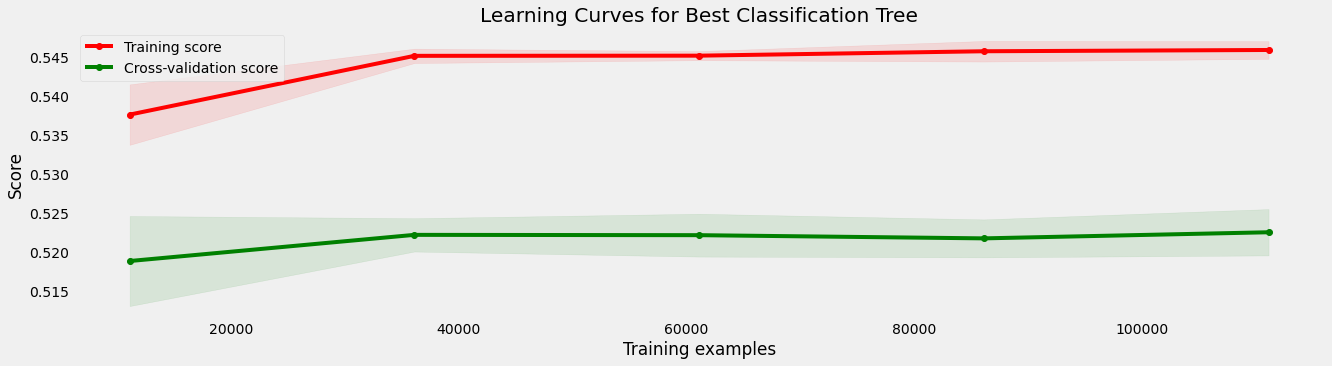

In [40]:
plot_learning_curve(best_model,'Learning Curves for Best Classification Tree',
                    train_X2,train_y_label)

### Feature Importance

Decision trees can not only be visualized to inspect the decision path for a given feature, but also provide a summary measure of the contribution of each feature to the model fit to the training data. 

The feature importance captures how much the splits produced by the feature helped to optimize the model's metric used to evaluate the split quality, which in our case is the Gini Impurity index. 

A feature's importance is computed as the (normalized) total reduction of this metric and takes into account the number of samples affected by a split. Hence, features used earlier in the tree where the nodes tend to contain more samples typically are considered of higher importance.

#### <font color="red"> =================================== Todo 8 =================================== </font>

<font color="blue"> Find the top 15 important features for our Tree Classifier and plot the feature importance </font>

           Feature Importance
month_9              0.010667
year_2016            0.010794
month_8              0.014666
t-7                  0.057994
t-8                  0.058767
t-11                 0.059043
t-10                 0.059100
t-5                  0.059469
t-4                  0.060679
t-12                 0.060722
t-2                  0.061821
t-1                  0.062316
t-9                  0.062390
t-3                  0.063405
t-6                  0.064469


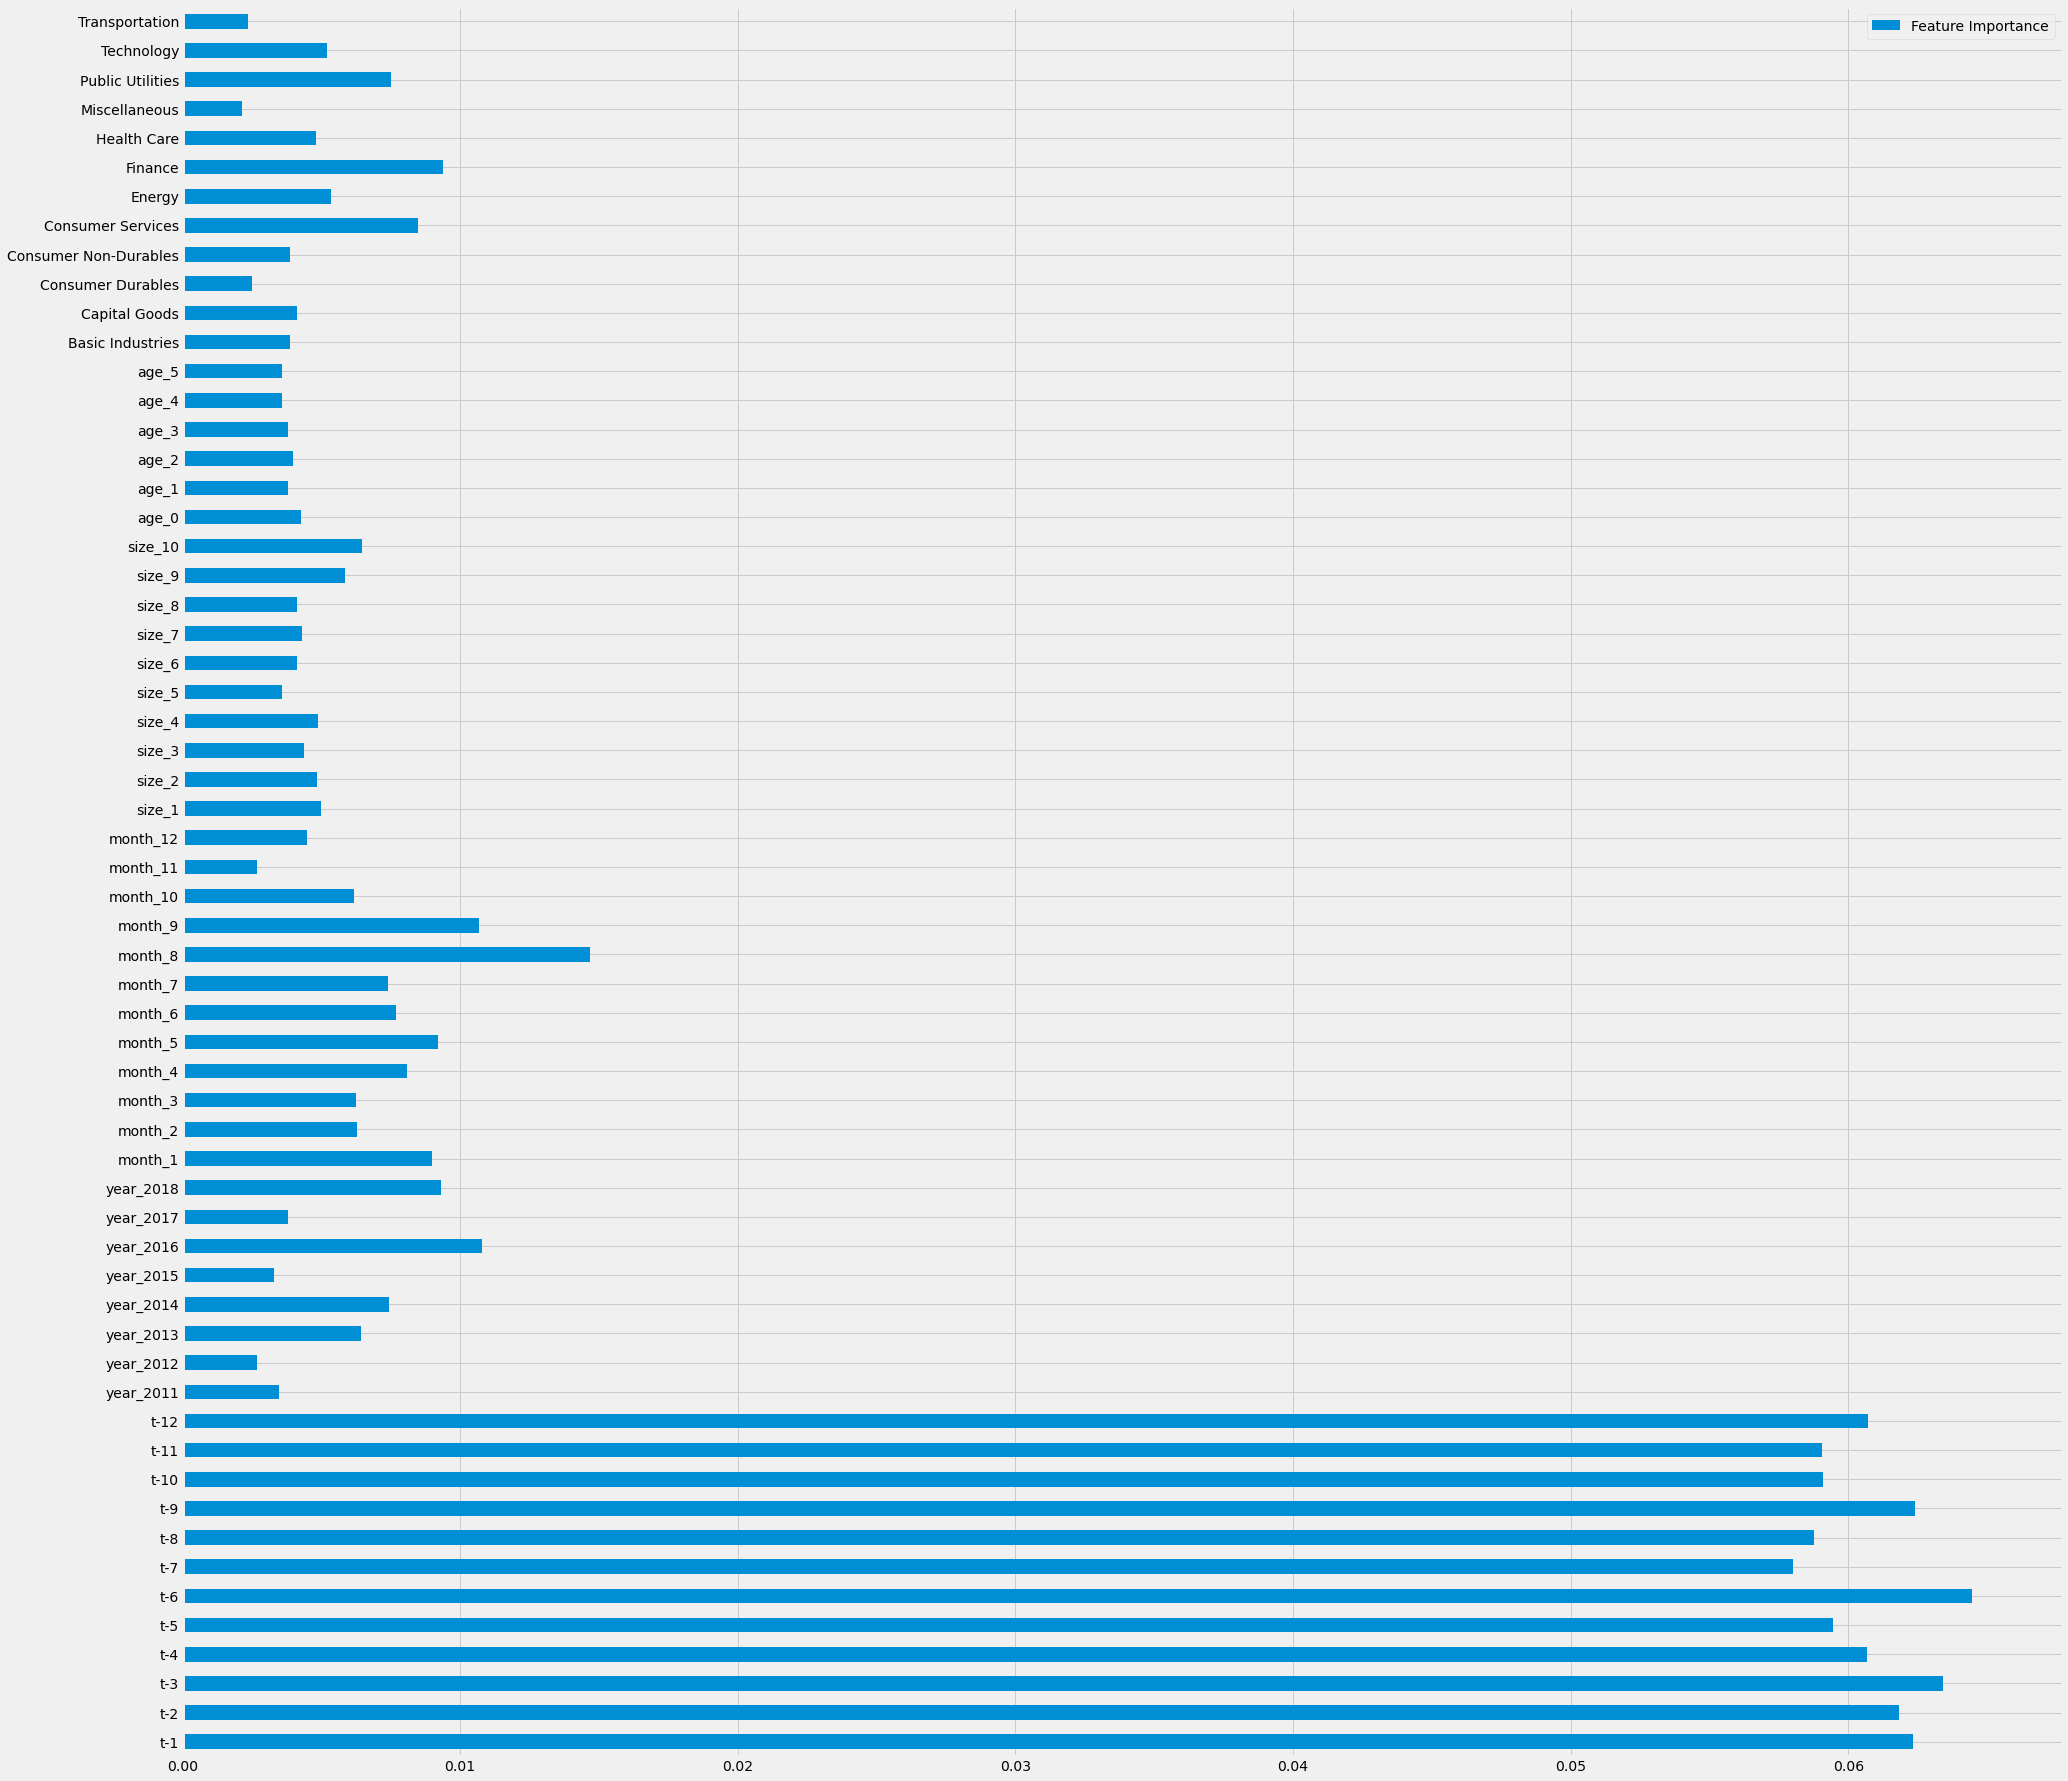

In [41]:
# Please uncomment the following code and implement your code here
# Check feature importance
train_X,test_X,train_y,test_y, train_y_label, test_y_label = train_test_split(X,
                                                 y,
                                                 y_binary,
                                                 test_size=0.1,
                                                 random_state=2021)
clf_model.fit(train_X, train_y_label)
feat_importance = clf_model.feature_importances_
df_feat = pd.DataFrame({'Feature Importance':feat_importance},index=train_X.columns)
df_feat.plot(kind='barh', figsize=(30,30))

df_sorted = df_feat.sort_values(by = "Feature Importance")
print(df_sorted.tail(15))

#### <font color="red"> =================================== Todo 8 End =================================== </font>